# Experiment 06 Analysis: PCA Components Sweep

This notebook analyzes the results of experiment 6, which sweeps over different PCA_OPTIMIZATION_COMPONENTS values for molecular optimization tasks. The analysis groups experiments by encoding method and PCA dimensionality, then calculates the relative improvement in optimization performance.

**Key Metrics:**
- Relative improvement: How much closer the optimized molecules get to the target compared to the initial molecules
- Comparison across different PCA compression levels (3, 5, 10, 20 components)
- Comparison across different encoding methods (HDC, FP, etc.)

In [27]:
import os
import time
import json
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
from rich.pretty import pprint
from pycomex.utils import is_experiment_archive
from pycomex.functional.experiment import Experiment

# Path configuration
PATH: str = os.getcwd()
RESULTS_PATH: str = os.path.join(PATH, 'results')

print(f'Working directory: {PATH}')
print(f'Results directory: {RESULTS_PATH}')

Working directory: /media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints
Results directory: /media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results


## Configuration

Configure the analysis parameters and visual styling.

In [28]:
# ============================================================================
# ANALYSIS CONFIGURATION
# ============================================================================

# Experiment prefix to filter for ex_06 experiments
EXPERIMENT_PREFIX = 'ex_06'

# Time filter: only load experiments from the last N weeks (None to disable)
MAX_AGE_WEEKS = 4

# Improvement calculation method:
# - 'experiment_native': Match optimize_molecule.py calculation
#       improvement = (mean(initial_dist) - mean(final_dist)) / mean(initial_dist) * 100
#       More robust, avoids outliers from small individual distances
#       This is what the experiment stores in e['summary/improvement_true_pct']
#
# - 'per_sample_average': Calculate improvement per sample then average
#       improvement = mean((initial_dist_i - final_dist_i) / initial_dist_i * 100)
#       More sensitive to individual sample performance
#       Can produce extreme values when individual initial distances are small
IMPROVEMENT_CALCULATION_METHOD = 'per_sample_average'  # Options: 'experiment_native', 'per_sample_average'

# Color palette for different encodings (will auto-generate if not specified)
# Set to None to use automatic color cycling from matplotlib
ENCODING_COLORS = {
    'hdc': '#4CEB99',   # Teal/green for HDC
    'fp': '#4C64EB',    # Blue for fingerprints
    'gnn': '#EBA14C',   # Orange for GNN (if present)
}

# Matplotlib style settings
plt.style.use('default')
plt.rcParams['font.family'] = 'Roboto Condensed'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print('✅ Configuration loaded')
print(f'📊 Improvement calculation method: {IMPROVEMENT_CALCULATION_METHOD}')

✅ Configuration loaded
📊 Improvement calculation method: per_sample_average


## Experiment Discovery and Filtering

Discover all experiment archives and filter for ex_06 experiments.

In [29]:
def select_experiment(experiment_name: str,
                      experiment_metadata: dict,
                      experiment_parameters: dict) -> bool:
    """
    Filter experiments based on prefix and age.
    
    Returns True if the experiment should be included in the analysis.
    """
    # Check for experiment prefix
    prefix_condition = (
        '__PREFIX__' in experiment_parameters and 
        EXPERIMENT_PREFIX in experiment_parameters['__PREFIX__']
    )
    
    # Check experiment age if MAX_AGE_WEEKS is set
    if MAX_AGE_WEEKS is not None:
        end_time: float = experiment_metadata.get('end_time', 0)
        if end_time > 0:
            end_datetime = datetime.datetime.fromtimestamp(end_time)
            now = datetime.datetime.now()
            max_delta = datetime.timedelta(weeks=MAX_AGE_WEEKS)
            age_condition = (now - end_datetime) <= max_delta
        else:
            age_condition = True  # Include if no timestamp
    else:
        age_condition = True
    
    return prefix_condition and age_condition


def extract_encoding(experiment: Experiment) -> str:
    """
    Dynamically extract the encoding method from experiment metadata.
    
    Looks for encoding identifiers in the experiment name.
    """
    name = experiment.metadata['name']
    
    # Check for encoding patterns in experiment name
    if '__hdc__' in name or '_hdc' in name:
        return 'hdc'
    elif '__fp__' in name or '_fp' in name:
        return 'fp'
    elif '__gnn__' in name or '_gnn' in name:
        return 'gnn'
    else:
        # Try to extract from path or parameters
        parts = name.split('__')
        if len(parts) >= 2:
            return parts[1]  # Assume second part is encoding
        return 'unknown'


def sort_experiment(experiment: Experiment) -> tuple:
    """
    Create a grouping key for the experiment.
    
    Groups by (encoding, pca_components) to aggregate results.
    """
    encoding = extract_encoding(experiment)
    pca_components = experiment.parameters.get('PCA_OPTIMIZATION_COMPONENTS', 'unknown')
    
    return (encoding, pca_components)


print('✅ Filter and sort functions defined')

✅ Filter and sort functions defined


In [30]:
# Discover experiment archive directories
experiment_namespace_paths: list[str] = [
    path
    for file_name in os.listdir(RESULTS_PATH)
    if os.path.isdir(path := os.path.join(RESULTS_PATH, file_name))
]

experiment_paths: list[str] = []
for namespace_path in experiment_namespace_paths:
    for dirpath, dirnames, filenames in os.walk(namespace_path):
        if is_experiment_archive(dirpath):
            experiment_paths.append(dirpath)
            dirnames.clear()  # Prevent further recursion

print(f'✅ Found {len(experiment_paths)} experiment archives in {len(experiment_namespace_paths)} namespaces')

✅ Found 37327 experiment archives in 57 namespaces


## Load Experiments

Load experiments from archives and filter based on selection criteria.

In [31]:
experiments: list[Experiment] = []

print(f'Loading experiments with prefix "{EXPERIMENT_PREFIX}"...')
time_start: float = time.time()

for experiment_path in experiment_paths:
    experiment_identifier: str = os.path.basename(experiment_path)
    
    # Check for required files
    experiment_data_path = os.path.join(experiment_path, Experiment.DATA_FILE_NAME)
    experiment_meta_path = os.path.join(experiment_path, Experiment.METADATA_FILE_NAME)
    
    if not os.path.exists(experiment_data_path) or not os.path.exists(experiment_meta_path):
        continue
    
    # Load metadata
    with open(experiment_meta_path) as file:
        experiment_metadata: dict = json.loads(file.read())
    
    if 'parameters' not in experiment_metadata:
        continue
    
    experiment_parameters: dict = {
        param: info['value']
        for param, info in experiment_metadata['parameters'].items()
        if 'value' in info
    }
    
    # Apply filter
    if select_experiment(
        experiment_name=experiment_metadata['name'],
        experiment_metadata=experiment_metadata,
        experiment_parameters=experiment_parameters
    ):
        try:
            experiment: Experiment = Experiment.load(experiment_path)
            experiments.append(experiment)
        except Exception as e:
            print(f'   ⚠️  Failed to load "{experiment_identifier}": {e}')

time_end: float = time.time()
duration: float = time_end - time_start

print(f'✅ Loaded {len(experiments)} experiments in {duration:.2f} seconds')

if len(experiments) == 0:
    print('⚠️  No experiments found! Check the EXPERIMENT_PREFIX and RESULTS_PATH.')
else:
    # Display example experiment
    example_exp = experiments[0]
    print(f'\nExample experiment:')
    print(f'  Name: {example_exp.metadata["name"]}')
    print(f'  Encoding: {extract_encoding(example_exp)}')
    print(f'  PCA components: {example_exp.parameters.get("PCA_OPTIMIZATION_COMPONENTS", "N/A")}')
    print(f'  Dataset: {example_exp.parameters.get("DATASET_NAME", "N/A")}')
    print(f'  Seed: {example_exp.parameters.get("SEED", "N/A")}')

Loading experiments with prefix "ex_06"...
✅ Loaded 112 experiments in 5.65 seconds

Example experiment:
  Name: optimize_molecule__hdc__clogp
  Encoding: hdc
  PCA components: 20
  Dataset: aqsoldb
  Seed: 3


## Group and Sort Experiments

Group experiments by encoding method and PCA components.

In [32]:
# Group experiments by (encoding, pca_components)
key_experiment_map: dict[tuple, list[Experiment]] = defaultdict(list)

for experiment in experiments:
    key: tuple = sort_experiment(experiment)
    key_experiment_map[key].append(experiment)

# Sort for consistent ordering
key_experiment_map = dict(sorted(key_experiment_map.items()))

print(f'✅ Grouped experiments into {len(key_experiment_map)} categories')
print(f'\nGrouping summary:')
for key, exps in key_experiment_map.items():
    encoding, pca_components = key
    print(f'  {encoding} | PCA={pca_components}: {len(exps)} experiments')

# Dynamically extract unique encodings and PCA values
unique_encodings = sorted(set(encoding for encoding, _ in key_experiment_map.keys()))
unique_pca_values = sorted(set(pca for _, pca in key_experiment_map.keys() if isinstance(pca, (int, float))))

print(f'\n📊 Detected encodings: {unique_encodings}')
print(f'📊 Detected PCA values: {unique_pca_values}')

✅ Grouped experiments into 8 categories

Grouping summary:
  fp | PCA=3: 14 experiments
  fp | PCA=5: 13 experiments
  fp | PCA=10: 13 experiments
  fp | PCA=20: 15 experiments
  hdc | PCA=3: 15 experiments
  hdc | PCA=5: 14 experiments
  hdc | PCA=10: 13 experiments
  hdc | PCA=20: 15 experiments

📊 Detected encodings: ['fp', 'hdc']
📊 Detected PCA values: [3, 5, 10, 20]


## Extract Optimization Results

Load optimization results from each experiment and calculate relative improvements.

In [33]:
# Store the improvement for each experiment
key_improvements_map: dict[tuple, list[float]] = defaultdict(list)

# Track statistics
total_samples = 0
total_experiments = 0
failed_loads = 0

print('Extracting optimization results...')
print(f'Using calculation method: {IMPROVEMENT_CALCULATION_METHOD}\n')

if IMPROVEMENT_CALCULATION_METHOD == 'experiment_native':
    print('  Formula: improvement = (mean(initial_dist) - mean(final_dist)) / mean(initial_dist) * 100')
    print('  (Matches optimize_molecule.py calculation)')
elif IMPROVEMENT_CALCULATION_METHOD == 'per_sample_average':
    print('  Formula: improvement = mean((initial_dist_i - final_dist_i) / initial_dist_i * 100)')
    print('  (Per-sample improvements averaged)')
else:
    raise ValueError(f'Unknown calculation method: {IMPROVEMENT_CALCULATION_METHOD}')

print()

for key, exps in key_experiment_map.items():
    encoding, pca_components = key
    
    for exp in exps:
        # Look for optimization results CSV
        results_csv_path = os.path.join(exp.path, 'optimization_results.csv')
        
        if not os.path.exists(results_csv_path):
            failed_loads += 1
            continue
        
        try:
            # Load results dataframe
            df = pd.read_csv(results_csv_path)
            
            if IMPROVEMENT_CALCULATION_METHOD == 'experiment_native':
                # Method 1: Calculate mean distances first, then improvement
                # This matches optimize_molecule.py lines 2245-2254
                mean_initial_distance = df['initial_distance_to_target'].mean()
                mean_true_distance = df['true_distance_to_target'].mean()
                
                if mean_initial_distance > 0:
                    improvement = (mean_initial_distance - mean_true_distance) / mean_initial_distance * 100
                else:
                    improvement = 0.0  # Edge case: already at target
            
            elif IMPROVEMENT_CALCULATION_METHOD == 'per_sample_average':
                # Method 2: Calculate improvement per sample, then average
                sample_improvements = []
                for _, row in df.iterrows():
                    initial_dist = row['initial_distance_to_target']
                    final_dist = row['true_distance_to_target']
                    
                    if initial_dist > 0:
                        sample_imp = (initial_dist - final_dist) / initial_dist * 100
                    else:
                        sample_imp = 0.0  # Already at target
                    
                    sample_improvements.append(sample_imp)
                
                improvement = np.mean(sample_improvements)
            
            # Store this experiment's improvement
            key_improvements_map[key].append(improvement)
            total_experiments += 1
            total_samples += len(df)
                
        except Exception as e:
            failed_loads += 1
            print(f'   ⚠️  Error processing {exp.metadata["name"]}: {e}')

print(f'\n✅ Processed {total_experiments} experiments with {total_samples} total optimization samples')
if failed_loads > 0:
    print(f'⚠️  Failed to load results from {failed_loads} experiments')

# Display statistics
print(f'\n📈 Experiments per group (boxplots will show distribution over these experiment-level improvements):')
for key, improvements in key_improvements_map.items():
    encoding, pca_components = key
    print(f'  {encoding} | PCA={pca_components}: {len(improvements)} experiments')

Extracting optimization results...
Using calculation method: per_sample_average

  Formula: improvement = mean((initial_dist_i - final_dist_i) / initial_dist_i * 100)
  (Per-sample improvements averaged)


✅ Processed 112 experiments with 24000 total optimization samples

📈 Experiments per group (boxplots will show distribution over these experiment-level improvements):
  fp | PCA=3: 14 experiments
  fp | PCA=5: 13 experiments
  fp | PCA=10: 13 experiments
  fp | PCA=20: 15 experiments
  hdc | PCA=3: 15 experiments
  hdc | PCA=5: 14 experiments
  hdc | PCA=10: 13 experiments
  hdc | PCA=20: 15 experiments


## Summary Statistics Table

Display mean and standard deviation of relative improvements.

In [34]:
from prettytable import PrettyTable

# Create summary table
table = PrettyTable()
table.field_names = ['Encoding', 'PCA Components', 'Mean Improvement (%)', 'Std Dev (%)', 'N Experiments']

for key, improvements in sorted(key_improvements_map.items()):
    encoding, pca_components = key
    
    if len(improvements) > 0:
        mean_improvement = np.mean(improvements)
        std_improvement = np.std(improvements)
        n_experiments = len(improvements)
        
        table.add_row([
            encoding.upper(),
            pca_components,
            f'{mean_improvement:.2f}',
            f'{std_improvement:.2f}',
            n_experiments
        ])

print('Summary: Mean improvement across experiments')
print('(Each value is the average of experiment-level means)')
print(table.get_string())

Summary: Mean improvement across experiments
(Each value is the average of experiment-level means)
+----------+----------------+----------------------+-------------+---------------+
| Encoding | PCA Components | Mean Improvement (%) | Std Dev (%) | N Experiments |
+----------+----------------+----------------------+-------------+---------------+
|    FP    |       3        |        18.72         |    43.68    |       14      |
|    FP    |       5        |         7.28         |    54.75    |       13      |
|    FP    |       10       |         6.27         |    57.02    |       13      |
|    FP    |       20       |        -9.71         |    58.24    |       15      |
|   HDC    |       3        |        12.44         |    41.83    |       15      |
|   HDC    |       5        |        -3.07         |    42.46    |       14      |
|   HDC    |       10       |        18.36         |    38.34    |       13      |
|   HDC    |       20       |        -7.82         |    49.43    |     

## Visualization: Boxplots by PCA Components

Create boxplots showing the distribution of relative improvements for each encoding method across different PCA component values.

In [35]:
# ============================================================================
# DYNAMIC COLOR ASSIGNMENT
# ============================================================================

def get_color_map(encodings: list[str], 
                  predefined_colors: dict = None) -> dict[str, str]:
    """
    Generate color mapping for encodings.
    
    Uses predefined colors if available, otherwise generates colors from
    matplotlib colormap.
    """
    color_map = {}
    
    # Use predefined colors where available
    if predefined_colors:
        color_map.update(predefined_colors)
    
    # Generate colors for remaining encodings
    missing_encodings = [enc for enc in encodings if enc not in color_map]
    
    if missing_encodings:
        # Use tab10 colormap for automatic color generation
        cmap = cm.get_cmap('tab10')
        for i, encoding in enumerate(missing_encodings):
            color_map[encoding] = cmap(i % 10)
    
    return color_map


# Generate color map dynamically
color_map = get_color_map(unique_encodings, ENCODING_COLORS)

print('🎨 Color mapping:')
for encoding, color in color_map.items():
    print(f'  {encoding}: {color}')

🎨 Color mapping:
  hdc: #4CEB99
  fp: #4C64EB
  gnn: #EBA14C


In [36]:
# ============================================================================
# PREPARE DATA FOR BOXPLOTS
# ============================================================================

# Organize data: for each PCA value, collect improvements for each encoding
pca_encoding_data = {}  # {pca_value: {encoding: [improvements]}}

for pca_value in unique_pca_values:
    pca_encoding_data[pca_value] = {}
    
    for encoding in unique_encodings:
        key = (encoding, pca_value)
        if key in key_improvements_map:
            pca_encoding_data[pca_value][encoding] = key_improvements_map[key]
        else:
            pca_encoding_data[pca_value][encoding] = []  # No data for this combination

print(f'✅ Organized data for {len(unique_pca_values)} PCA values and {len(unique_encodings)} encodings')

✅ Organized data for 4 PCA values and 2 encodings



💾 Saved figure to: /media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/ex_06_pca_components_analysis.pdf


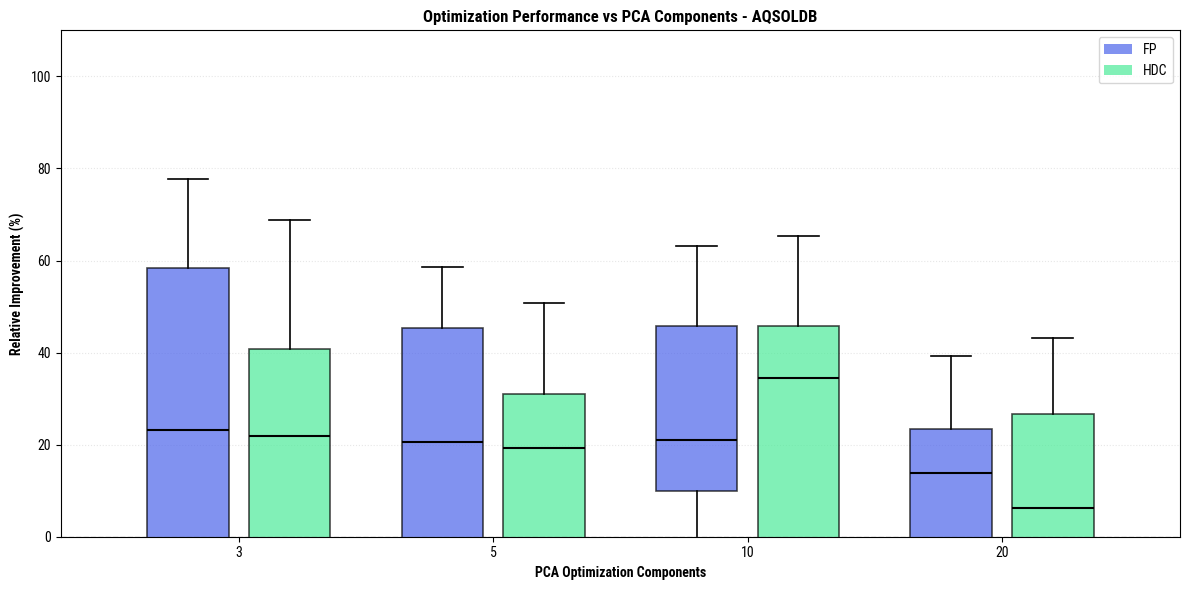

In [37]:
# ============================================================================
# CREATE BOXPLOT VISUALIZATION
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

# Calculate positions for boxplots
n_encodings = len(unique_encodings)
n_pca = len(unique_pca_values)
box_width = 0.8 / n_encodings  # Width of each box
group_spacing = 1.0  # Spacing between PCA value groups

# Collect all boxplot data and positions
all_positions = []
all_data = []
all_colors = []
all_labels = []

for pca_idx, pca_value in enumerate(unique_pca_values):
    group_center = pca_idx * group_spacing
    
    for enc_idx, encoding in enumerate(unique_encodings):
        # Calculate position for this box
        offset = (enc_idx - (n_encodings - 1) / 2) * box_width
        position = group_center + offset
        
        # Get data for this encoding-PCA combination
        data = pca_encoding_data[pca_value].get(encoding, [])
        
        if len(data) > 0:  # Only plot if we have data
            all_positions.append(position)
            all_data.append(data)
            all_colors.append(color_map[encoding])
            all_labels.append(encoding if pca_idx == 0 else '')  # Label only first group

# Create boxplots
bp = ax.boxplot(
    all_data,
    positions=all_positions,
    widths=box_width * 0.8,
    patch_artist=True,
    showfliers=True,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(linewidth=1.2),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker='o', markersize=3, alpha=0.3)
)

# Color the boxes
for patch, color in zip(bp['boxes'], all_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Set x-axis labels (PCA values)
ax.set_xticks([i * group_spacing for i in range(n_pca)])
ax.set_xticklabels([str(pca) for pca in unique_pca_values])
ax.set_xlabel('PCA Optimization Components', fontweight='bold')
ax.set_ylim([0, 110])

# Set y-axis label
ax.set_ylabel('Relative Improvement (%)', fontweight='bold')

# Add horizontal line at y=0 for reference
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[enc], alpha=0.7, label=enc.upper()) 
                   for enc in unique_encodings]
ax.legend(handles=legend_elements, loc='best', frameon=True, fancybox=True)

# Dynamically extract title information from experiments
if len(experiments) > 0:
    example_exp = experiments[0]
    dataset_name = example_exp.parameters.get('DATASET_NAME', 'Unknown')
    title = f'Optimization Performance vs PCA Components - {dataset_name.upper()}'
else:
    title = 'Optimization Performance vs PCA Components'

ax.set_title(title, fontweight='bold', fontsize=12)

# Grid for readability
ax.grid(axis='y', alpha=0.3, linestyle=':')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Save figure
output_path = os.path.join(PATH, 'ex_06_pca_components_analysis.pdf')
fig.savefig(output_path, bbox_inches='tight')
print(f'\n💾 Saved figure to: {output_path}')

fig

## Additional Analysis: Mean Improvement Trends

Plot mean improvement with error bars to see trends more clearly.

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line for each encoding
for encoding in unique_encodings:
    means = []
    stds = []
    
    for pca_value in unique_pca_values:
        key = (encoding, pca_value)
        if key in key_improvements_map and len(key_improvements_map[key]) > 0:
            means.append(np.mean(key_improvements_map[key]))
            stds.append(np.std(key_improvements_map[key]))
        else:
            means.append(np.nan)
            stds.append(np.nan)
    
    # Plot with error bars
    ax.errorbar(
        unique_pca_values,
        means,
        yerr=stds,
        marker='o',
        markersize=8,
        linewidth=2,
        capsize=5,
        label=encoding.upper(),
        color=color_map[encoding],
        alpha=0.8
    )

ax.set_xlabel('PCA Optimization Components', fontweight='bold')
ax.set_ylabel('Mean Relative Improvement (%)', fontweight='bold')
ax.set_title('Mean Optimization Performance vs PCA Components', fontweight='bold', fontsize=12)
ax.legend(loc='best', frameon=True, fancybox=True)
ax.grid(True, alpha=0.3, linestyle=':')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Save figure
output_path = os.path.join(PATH, 'ex_06_pca_mean_trends.pdf')
fig.savefig(output_path, bbox_inches='tight')
print(f'💾 Saved figure to: {output_path}')

💾 Saved figure to: /media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/ex_06_pca_mean_trends.pdf


## Summary

Key findings from the PCA components sweep analysis.

In [39]:
print('=' * 70)
print('EXPERIMENT 06 ANALYSIS SUMMARY')
print('=' * 70)
print(f'\nCalculation method: {IMPROVEMENT_CALCULATION_METHOD}')
print(f'Total experiments analyzed: {total_experiments}')
print(f'Total optimization samples across all experiments: {total_samples}')
print(f'\nEncodings tested: {", ".join([e.upper() for e in unique_encodings])}')
print(f'PCA component values: {unique_pca_values}')

# Find best performing combination
best_key = None
best_mean = -np.inf

for key, improvements in key_improvements_map.items():
    if len(improvements) > 0:
        mean_imp = np.mean(improvements)
        if mean_imp > best_mean:
            best_mean = mean_imp
            best_key = key

if best_key:
    encoding, pca_components = best_key
    best_std = np.std(key_improvements_map[best_key])
    n_exp = len(key_improvements_map[best_key])
    print(f'\n🏆 Best performing configuration:')
    print(f'   Encoding: {encoding.upper()}')
    print(f'   PCA Components: {pca_components}')
    print(f'   Mean Improvement: {best_mean:.2f}% ± {best_std:.2f}%')
    print(f'   Based on {n_exp} experiments')

print('\nNote: Statistics are calculated over experiment-level improvements.')
print('Each experiment optimizes multiple molecules, and we report the')
print('distribution of per-experiment improvement values.')
print('\n' + '=' * 70)

EXPERIMENT 06 ANALYSIS SUMMARY

Calculation method: per_sample_average
Total experiments analyzed: 112
Total optimization samples across all experiments: 24000

Encodings tested: FP, HDC
PCA component values: [3, 5, 10, 20]

🏆 Best performing configuration:
   Encoding: FP
   PCA Components: 3
   Mean Improvement: 18.72% ± 43.68%
   Based on 14 experiments

Note: Statistics are calculated over experiment-level improvements.
Each experiment optimizes multiple molecules, and we report the
distribution of per-experiment improvement values.

